# Mục lục

1. [Giới thiệu](#intro)
2. [EDA](#eda)
3. [Tiền xử lý](#preprocessing)
4. [Tfidf](#tfidf)
    1. [Giới thiệu tfidf](#tfidf-intro)
    2. [Chuyển đổi sang tf-idf](#tfidf-appl)
5. [Hồi quy logistic](#lg)
    1. [Kiểm soát (regularize)](#reg)
        1. [L1](#l1)
        2. [L2](#l2)
    2. [Xác thực (validating)](#valid)
    3. [Diễn dịch mô hình](#interpret)
        1. [Odds](#odds)
        2. [Odds ratio](#odds-ratio)
6. [Máy vector hỗ trợ (SVM)](#svm)
7. [Tham khảo](#ref)

# (1) Giới thiệu<a name="intro"></a>

Nhận dạng bình luận độc hại (toxic comment classification).  
Bình luận độc hại là những bình luận:
* chửi tục
* phân biệt (vùng miền, giới tính)
* lăng mạ
* cổ súy bạo lực (vd: "hạng này bắn bỏ", "tử hình cả dòng họ nó").

Đầu vào là một bình luận đầu ra sẽ là một nhãn "0" hoặc "1" với "1" là bình luận độc hại và "0" là bình thường.

# (2) EDA<a name="eda"></a>

In [1]:
import pandas as pd
import numpy as np
from seaborn import countplot

In [2]:
raw_data = pd.read_csv("data/raw_data.csv")
raw_data.tail()

,id,comment,is_toxic
12671,12671,Bảo Bảo hum đúng là như lozz thật xem clip tắt...,1
12672,12672,Trần Hà hên là mày khôn ra,0
12673,12673,Bích Huyền chuyện dì cũng có thể xảy ra,0
12674,12674,Nguyễn Trân Trân dm t nhìn giống m vl :)),1
12675,12675,Nguyễn Trang mới đọc nãy,0


Dữ liệu thu được gồm 12675 bình luận. Gồm các trường id, comment, is_toxic.

In [3]:
ex = [raw_data.loc[98].comment, raw_data.loc[108].comment, raw_data.loc[1964].comment]
print(ex)

['Việt Trinh', 'Hương Gà k ck mình hơn mình 5t. Mệt lắm =)))))', '👉Nhận order mua hộ vận chuyện hàng Trung - Việt 😊\n👉 Hàng nội địa giá tận gốc.\n👉Chuyên sỉ (hàng có sẵn)\n\n😘Like Trang https://m.facebook.com/101837188158750/photos/a.101838121491990/103918364617299/?type=3&source=44 để cập nhật những món khoái khẩu nhé 🥰']


Dữ liệu comment có chứa tên riêng, từ viết tắt, emoji, url, sai chính tả, thiếu dấu, teencode.

<AxesSubplot:xlabel='is_toxic', ylabel='count'>

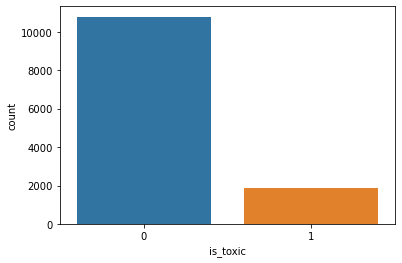

In [4]:
countplot(raw_data.is_toxic)

In [5]:
num_0, num_1 = raw_data.is_toxic.value_counts().values
print(f"Các bình luận độc hại chiếm {round(num_1 / (num_0 + num_1) * 100, 2)}% tổng số bình luận.")

Các bình luận độc hại chiếm 14.89% tổng số bình luận.


# (3) Tiền xử lý<a name="preprocessing"></a>

Tiền xử lý bao gồm các việc được thực hiện tuần tự:
1. Bỏ khoảng trắng thừa, đưa về viết thường
2. Bỏ emoji, url, dấu câu
3. Chuyển đổi chữ viết tắt sang đầy đủ, được thực hiện bằng cách dò từ điển (các bước thực hiện ở hình dưới)
4. Tách từ (tokenize). Sử dụng [VnCoreNLP wordsegmenter](https://github.com/vncorenlp/VnCoreNLP).
5. Loại bỏ stop word. Danh sách stop word [tại đây](https://xltiengviet.fandom.com/wiki/Danh_s%C3%A1ch_stop_word)

![Abbreviation chart](img/abbreviation_chart.png)

In [6]:
from preprocess import preprocess_df

In [7]:
X = raw_data.drop(["id"], axis=1)

In [8]:
X_proc = preprocess_df(X)

In [9]:
X_proc = X_proc.replace("", np.NaN)
X_proc.isnull().sum()

comment     185
is_toxic      0
dtype: int64

In [10]:
X = raw_data.drop(["id"], axis=1)
X[X_proc.isnull().any(axis=1)]

,comment,is_toxic
102,"""=))""",0
242,.,0
267,🔴,0
317,😁😁😁,0
426,???,0
...,...,...
12226,😭😭😭,0
12326,😂😂,0
12387,-))))),0
12390,♥,0


Sau khi tiền xử lý có 185 bình luận bị trống, những bình luận này thường chỉ chứa toàn stop word hoặc chỉ chứa icon, emoji. Ta sẽ bỏ chúng đi.

In [11]:
X_proc = X_proc.dropna()
X_proc.to_csv("data/preprocessed_data.csv", index=False)
X = X_proc.reset_index().drop(["index"], axis=1)

In [12]:
X.tail()

,comment,is_toxic
12486,bảo bảo hum đúng lồn thật xem clip tắt lứng,1
12487,trần hà hên mày khôn,0
12488,bích huyền chuyện dì xảy,0
12489,nguyễn_trân_trân địt_mẹ tao nhìn giống mày vãi...,1
12490,nguyễn_trang mới đọc nãy,0


![Clean cloud](img/clean_cloud.png)
![Toxic cloud](img/toxic_cloud.png)

Word cloud sau khi đã qua tiền xử lý.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# khai báo hàm kfold
def kfold(model, X, y, n, random_state=None, verbose=False):
    skf = StratifiedKFold(n_splits=n, shuffle=True, random_state=None)
    valid_f1 = []
    for i, (train, valid) in enumerate(skf.split(X, y)):
        if verbose:
            print(f"[FOLD {i + 1}]")
        model.fit(X[train], y[train])
        y_vp = model.predict(X[valid])
        valid_f1.append(f1_score(y[valid], y_vp))
        if verbose:
            print(f"F1 = {valid_f1[-1]}")
        
    return np.mean(valid_f1), np.std(valid_f1), valid_f1

# (4) TF-IDF<a name="tfidf"></a>

## 4.A. Giới thiệu tf-idf<a name="tfidf-intro"></a>

Term frequency inverse document frequency được tính bằng công thức:  
$tf-idf(t, d) = tf(t, d) * idf(t)$

*t là chữ và d là bình luận.*

Theo sklearn **tf(t, d)** được tính bằng **CountVectorizer**. 

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [15]:
corpus = ["tôi đi học", "tôi đi chơi"]
exvec = CountVectorizer()
exvec.fit(corpus)
exvec.get_feature_names()

['chơi', 'học', 'tôi', 'đi']

In [16]:
ex = exvec.transform(corpus).toarray()
ex

array([[0, 1, 1, 1],
       [1, 0, 1, 1]])

**smooth_idf=False**  
$ idf(t) = log(\frac{n}{df(t)}) + 1 $

**smooth_idf=True**  
$ idf(t) = log(\frac{n + 1}{df(t) + 1}) + 1 $


*n là tổng số lượng các bình luận*  
*df(t) là số bình luận trong đó có chứa t*

In [17]:
transformer = TfidfTransformer()
transformer.fit(ex)
transformer.idf_

array([1.40546511, 1.40546511, 1.        , 1.        ])

$tf-idf(\text{"tôi đi học"}) = [0 * 1.41,  1 * 1.41,  1 * 1,  1 * 1] = [0. ,  1.41,  1,  1]$

Thư viện sklearn sau đó thực hiện **normalization** trên vector tf-idf bằng công thức:  
$v_{norm} = \frac{v}{\sqrt(v_{1}^{2} + v_{2}^{2} + ... + v_{n}^{2})} = [0., 0.7, 0.5, 0.5]$

In [18]:
transformer.transform(ex).toarray()

array([[0.        , 0.70490949, 0.50154891, 0.50154891],
       [0.70490949, 0.        , 0.50154891, 0.50154891]])

## 4.B. Thực hiện chuyển đổi sang tf-idf<a name="tfidf-appl"></a>

Trong sklearn có TfidfVectorizer tương đương với việc thực hiện CountVectorizer sau đó TfidfTransformer.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
corpus = X.comment.values
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=3000)
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [21]:
X_vec = vectorizer.transform(X.comment.values)
y = X.is_toxic

# (5) Hồi quy logistic<a name="lg"></a>

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
lg = LogisticRegression(solver="liblinear")

In [24]:
mean_f1, std_f1, _ = kfold(model=lg, X=X_vec, y=y, n=10, random_state=42, verbose=True)
print(f"\nMean F1 = {mean_f1} - Std F1 = {std_f1}")

[FOLD 1]
F1 = 0.7296416938110748
[FOLD 2]
F1 = 0.742671009771987
[FOLD 3]
F1 = 0.695364238410596
[FOLD 4]
F1 = 0.7278688524590163
[FOLD 5]
F1 = 0.7133333333333333
[FOLD 6]
F1 = 0.7157190635451506
[FOLD 7]
F1 = 0.7721518987341772
[FOLD 8]
F1 = 0.7450980392156863
[FOLD 9]
F1 = 0.7284768211920529
[FOLD 10]
F1 = 0.6887417218543047

Mean F1 = 0.7259066672327379 - Std F1 = 0.023212774024961698


## 5.A. Cơ chế kiểm soát (regularization)<a name="reg"></a>

### L1 regularization<a name="l1"></a>

Tối ưu hàm mất mát sau: $\underset{\theta,c}{min}\frac{1}{2}\theta^{T}\theta+C\displaystyle\sum^{n}_{i=1}\log(\exp(-y_{i}(X_{i}^{T}\theta+c))+1)$

L1 loại bỏ các feature không quan trọng bằng cách cho $\theta$ tương ứng về 0.

In [25]:
import matplotlib.pyplot as plt

In [26]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
l1_f1_valid = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l1",
                        max_iter=1000)
    mean_f1, _, _ = kfold(lg, X_vec, y, 10, random_state=42)
    l1_f1_valid.append(mean_f1)

### L2 regularization<a name="l2"></a>

Tối ưu hàm mất mát sau: $\underset{\theta,c}{min}\lvert\lvert{\theta}\rvert\rvert_{1}+C\displaystyle\sum^{n}_{i=1}\log(\exp(-y_{i}(X_{i}^{T}\theta+c))+1)$

L2 giảm $\theta$ của các feature không quan trọng về con số rất nhỏ.

In [27]:
c_list = [0.12, 0.24, 0.48, 1.62, 2.88, 5.2, 10.12]
l2_f1_valid = []
for i in c_list:
    lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l2",
                        max_iter=1000)
    mean_f1, _, _ = kfold(lg, X_vec, y, 10, random_state=42)
    l2_f1_valid.append(mean_f1)

Text(0, 0.5, 'f1-score')

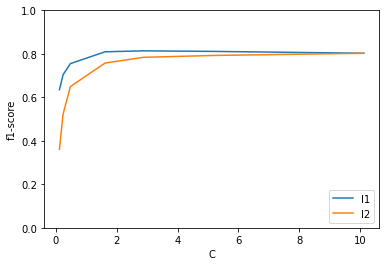

In [28]:
plt.plot(c_list, l1_f1_valid, label="l1")
plt.plot(c_list, l2_f1_valid, label="l2")
plt.ylim(0.0, 1.0)
plt.legend(loc="lower right")
plt.xlabel("C")
plt.ylabel("f1-score")

Cả hai phương pháp tốt nhất khi $C \approx 1.8$ nhưng f1-score của L1 tốt hơn L2.

## 5.B. Xác thực (validating)<a name="valid"></a>

In [29]:
lg = LogisticRegression(random_state=41,
                        solver="liblinear",
                        C=i,
                        penalty="l1",
                        max_iter=1000)

In [30]:
mean_f1, std_f1, _ = kfold(model=lg, X=X_vec, y=y, n=10, random_state=42, verbose=True)
print(f"\nMean F1 = {mean_f1} - Std F1 = {std_f1}")

[FOLD 1]
F1 = 0.7833333333333334
[FOLD 2]
F1 = 0.8459383753501402
[FOLD 3]
F1 = 0.7796610169491525
[FOLD 4]
F1 = 0.8021978021978022
[FOLD 5]
F1 = 0.7679558011049724
[FOLD 6]
F1 = 0.8205128205128205
[FOLD 7]
F1 = 0.8254847645429363
[FOLD 8]
F1 = 0.8116710875331565
[FOLD 9]
F1 = 0.776536312849162
[FOLD 10]
F1 = 0.8067226890756302

Mean F1 = 0.8020014003449105 - Std F1 = 0.02365500750280194


Với 10-fold ta thấy kết quả mô hình là vào khoảng $0.8\pm0.02$.

## 5.C. Diễn dịch mô hình<a name="interpret"></a>

In [31]:
lg.fit(X_vec, y)

LogisticRegression(C=10.12, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=41, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
remain_feature = np.count_nonzero(lg.coef_[0])
print(f"l1 giảm số feature từ {len(lg.coef_[0])} còn {remain_feature}")

l1 giảm số feature từ 3000 còn 1256


### Odds<a name="odds"></a>

$\text{odds} = \frac{P(y=1)}{P(y=0)} = exp(\sum_{i=0}^{n}\theta_{i}x_{i})$

Odds cho biết khả năng của một bình luận thuộc về lớp 1 cao hơn bao nhiêu lần so với lớp 0.

In [33]:
test_corp = {"comment": [
    "Từ nhỏ đến giờ tao chưa bao giờ ăn thịt chó:)))))) thề", 
    "Dắt bọn này đi bảo vệ Nô khỏi bị cướp tiền, nhưng ko cẩn thận có khi lại mất chó kaka 😄😆😆😂😂", 
    "h m muốn sao hả con chó?????"]}
test_df = pd.DataFrame(test_corp)
test_df = preprocess_df(test_df)
test_df_vec = vectorizer.transform(test_df.comment.values).toarray()

p = lg.predict_proba(test_df_vec)
odds = p[:, 1] / p[:, 0]

for i, c in enumerate(test_corp["comment"]):
    print(f"[Bình luận] {c}\n[odds] {odds[i]}\n")

[Bình luận] Từ nhỏ đến giờ tao chưa bao giờ ăn thịt chó:)))))) thề
[odds] 0.00203563751825595

[Bình luận] Dắt bọn này đi bảo vệ Nô khỏi bị cướp tiền, nhưng ko cẩn thận có khi lại mất chó kaka 😄😆😆😂😂
[odds] 0.007347954559654135

[Bình luận] h m muốn sao hả con chó?????
[odds] 10.697938617672706



Cả ba bình luận trên đều có từ chó, nhưng chỉ có bình luận thứ 3 là có ý công kích nên odd của nó cũng cao hơn hai bình luận còn lại.

### Odds ratio<a name="odds-ratio"></a>

  $\text{odds ratio} = \frac{odds_{x_{i}+1}}{odds} = exp(\theta_{j})$

**odds ratio** của feature $x_{j}$ cho biết khả năng của bình luận thuộc về lớp 1 tăng thêm bao nhiêu nếu nó tăng thêm 1.

In [34]:
dic = {"word": vectorizer.get_feature_names(),
       "weight": lg.coef_[0],
       "odds_ratio": np.exp(lg.coef_[0])}
table = pd.DataFrame(dic)

In [35]:
table.sort_values(by=["odds_ratio"], axis=0, ascending=False).head(10)

,word,weight,odds_ratio
1238,lồn,33.145761,2.483254e+14
2923,địt,32.607011,1.448922e+14
2925,địt_mẹ,30.919292,2.679649e+13
2570,vãi lồn,30.697597,2.146826e+13
2832,đéo,29.677097,7.737481e+12
443,con_mẹ,27.513414,8.890452e+11
55,ba_que,26.866335,4.654800e+11
563,cặc,25.953290,1.867973e+11
95,buồi,22.729337,7.434050e+09
2026,súc_vật,20.412426,7.328310e+08


Ta thấy 10 từ có odds ratio cao nhất đều là các từ chửi tục nên có thể kết luận mô hình đang làm đúng việc.

# (6) Máy vector hỗ trợ (SVM)<a name="svm"></a>

In [36]:
from sklearn.svm import LinearSVC

In [37]:
svm = LinearSVC(C=1.2, tol=1e-3, penalty="l1", dual=False, random_state=42)

In [38]:
mean_f1, std_f1, _ = kfold(model=svm, X=X_vec, y=y, n=10, random_state=42, verbose=True)
print(f"\nMean F1 = {mean_f1} - Std F1 = {std_f1}")

[FOLD 1]
F1 = 0.8435754189944134
[FOLD 2]
F1 = 0.8
[FOLD 3]
F1 = 0.8205128205128205
[FOLD 4]
F1 = 0.8047337278106509
[FOLD 5]
F1 = 0.803370786516854
[FOLD 6]
F1 = 0.7793696275071632
[FOLD 7]
F1 = 0.8197674418604651
[FOLD 8]
F1 = 0.8491620111731844
[FOLD 9]
F1 = 0.8483146067415731
[FOLD 10]
F1 = 0.7859237536656891

Mean F1 = 0.8154730194782813 - Std F1 = 0.023926824515288457


SVM cho kết quả có cải thiện hơn so với hồi quy logistic.

# (7) Tham khảo<a name="ref"></a>

1. https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
2. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
3. https://christophm.github.io/interpretable-ml-book/logistic.html